## Shift detection methods

So far TOAD only comes with ASDETECT [Boulton+Lenton2019]. But you can also implement your own shifts detection algorithm. You basically just need a function which transforms the timeseries in each grid cell into a time series of "abruptness", with floating point values between -1 (negative shift) and 1 (positive shift).


In [2]:
# Prerequisites
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [3]:
data = (
    xr.open_dataset("test_data/garbe_2020_antarctica.nc")
    .coarsen(x=2, y=2, GMST=2, boundary="trim")
    .reduce(np.mean)
)

Let's build a simple shifts detection algorithm


In [4]:
def compute_shift_intensity(values_1d: np.ndarray, window_size=5):
    """
    Simple function to compute shift intensity for each timestep [-1, 1]
    where -1 is strong negative shift, +1 is strong positive shift
    """

    data = np.array(values_1d)
    window_size = max(3, len(data) // 15)  # Ensure reasonable window size

    # Initialize results array
    intensity = np.zeros(len(data))

    # Calculate max possible difference for normalization
    max_diff = np.max(data) - np.min(data)
    if max_diff == 0:
        return intensity

    # For each point (except edges), compare before/after windows
    for i in range(window_size, len(data) - window_size):
        window1 = data[i - window_size : i]
        window2 = data[i : i + window_size]

        mean1 = np.mean(window1)
        mean2 = np.mean(window2)

        # Normalize difference to [-1, 1]
        # Positive means increasing, negative means decreasing
        intensity[i] = (mean2 - mean1) / max_diff
        intensity[i] = min(intensity[i], 1)
        intensity[i] = max(intensity[i], -1)

    return intensity

So this function takes a single timeseries with values and timesteps


(-1.0, 1.0)

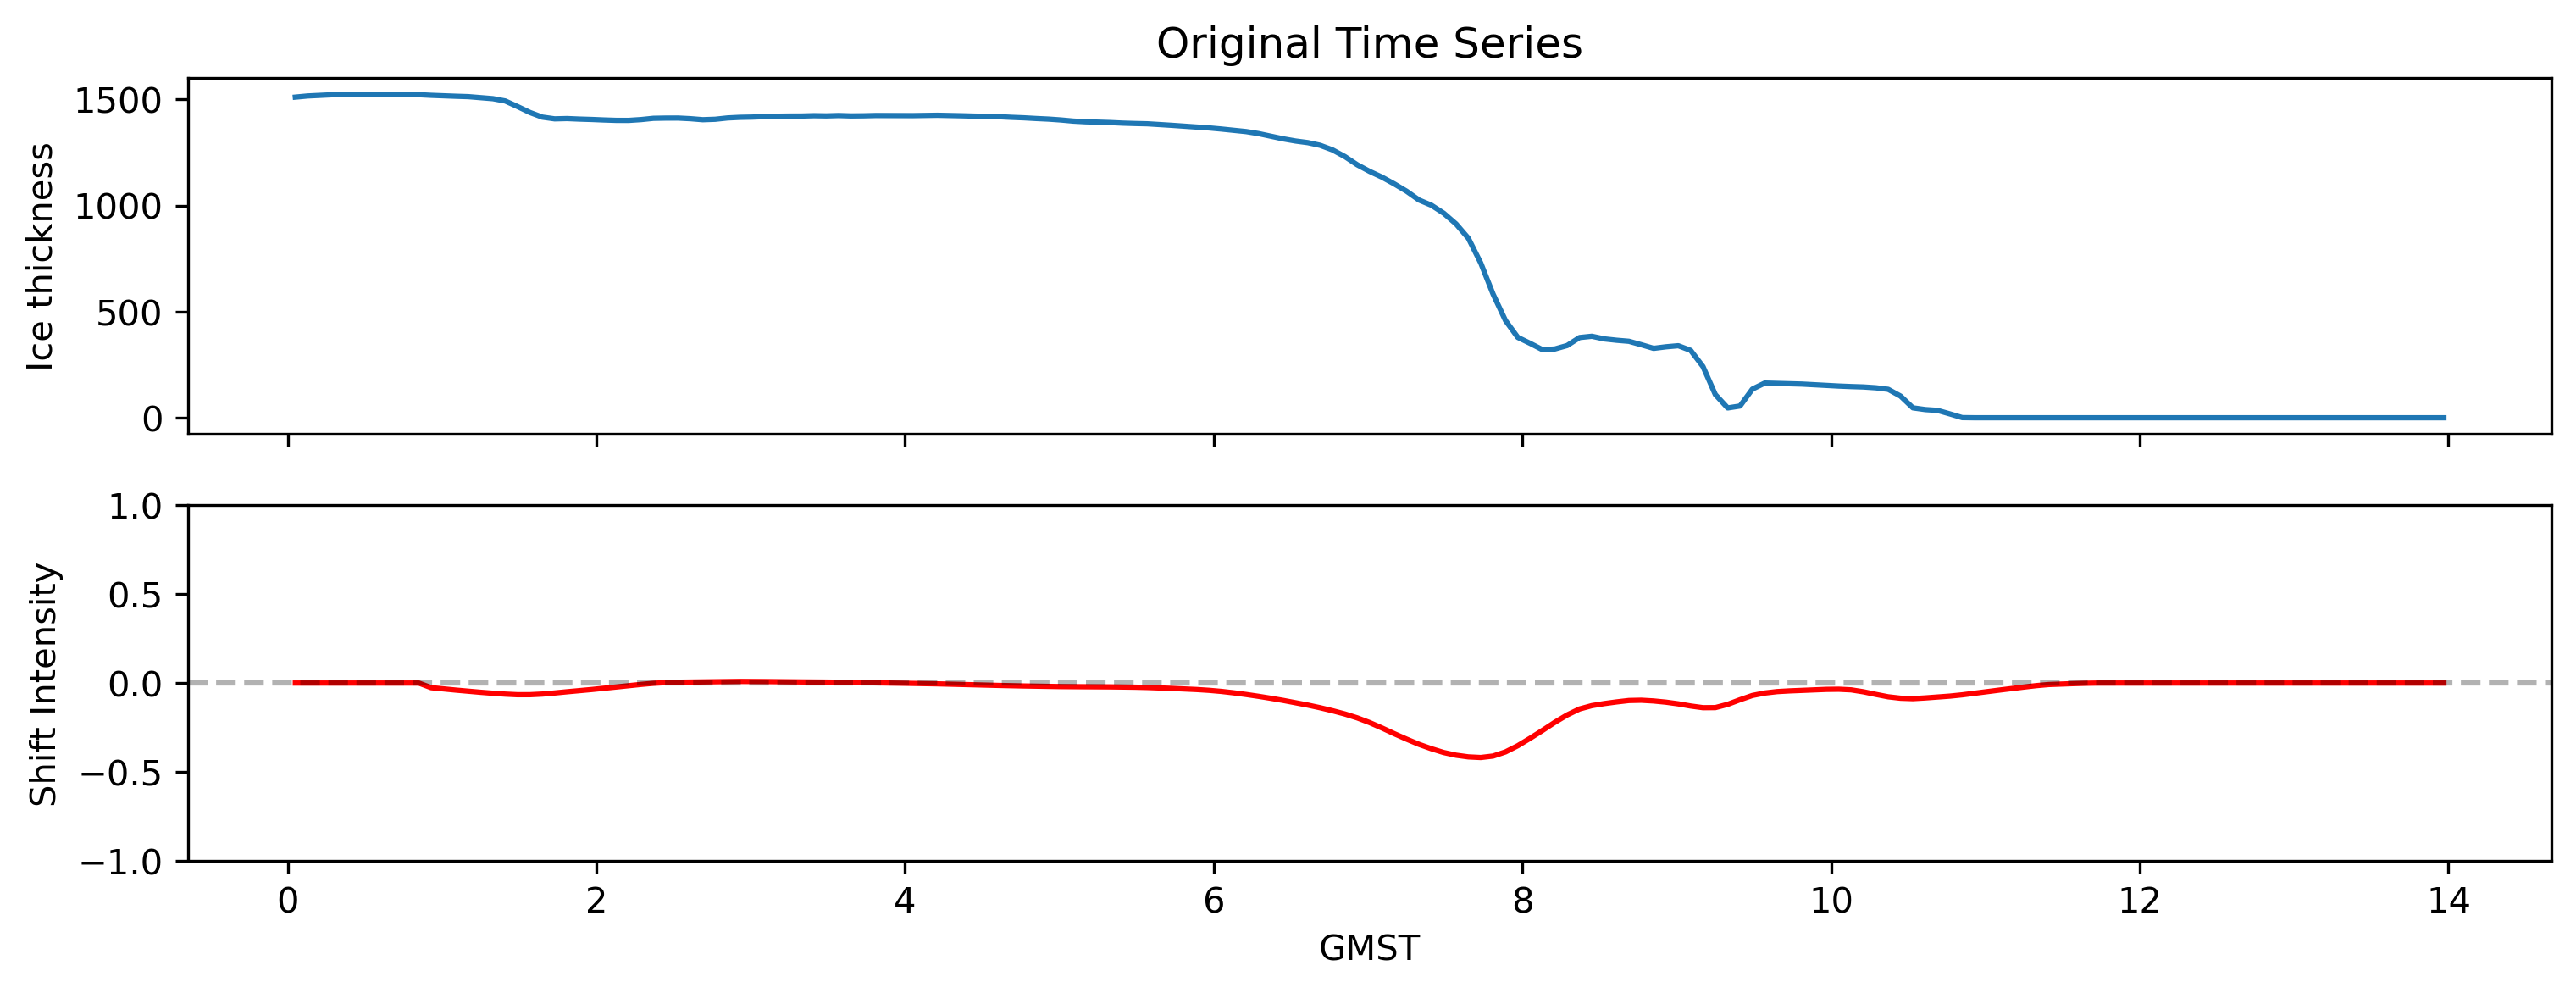

In [12]:
# get sample timeseries from dataset
ts = data.sel(x=-1032000, y=-1032000, method="nearest").thk

# Calculate shift intensity
intensity = compute_shift_intensity(ts.values)

# Plot original data and shift intensity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
ax1.plot(ts.GMST, ts.values)
ax1.set_title("Original Time Series")
ax2.plot(ts.GMST, intensity, color="red")
ax2.axhline(y=0, color="k", linestyle="--", alpha=0.3)
ax1.set_ylabel("Ice thickness")
ax2.set_ylabel("Shift Intensity")
ax2.set_xlabel("GMST")
ax2.set_ylim(-1, 1)

Now we can define a new shifts method by abstracting the `ShiftsMethod` class in `toad.shifts`.


In [13]:
from toad.shifts import ShiftsMethod


class MY_SHFITS_METHOD(ShiftsMethod):
    # You can pass parameters to the method like this
    def __init__(self, window_size=5):
        self.window_size = window_size

    # This function is called by TOAD on each gridcell independently.
    def fit_predict(
        self,
        values_1d: np.ndarray,
        times_1d: np.ndarray,
    ) -> np.ndarray:
        shifts = compute_shift_intensity(values_1d, window_size=self.window_size)
        return shifts

And then we can pass this method into `compute_shifts`.


In [14]:
from toad import TOAD

td = TOAD(data, time_dim="GMST")
td.compute_shifts("thk", method=MY_SHFITS_METHOD(window_size=10), overwrite=True)

INFO: Applying detector MY_SHFITS_METHOD to thk


(<Figure size 4500x600 with 1 Axes>,
 array([<Axes: ylabel='#thk_dts'>], dtype=object))

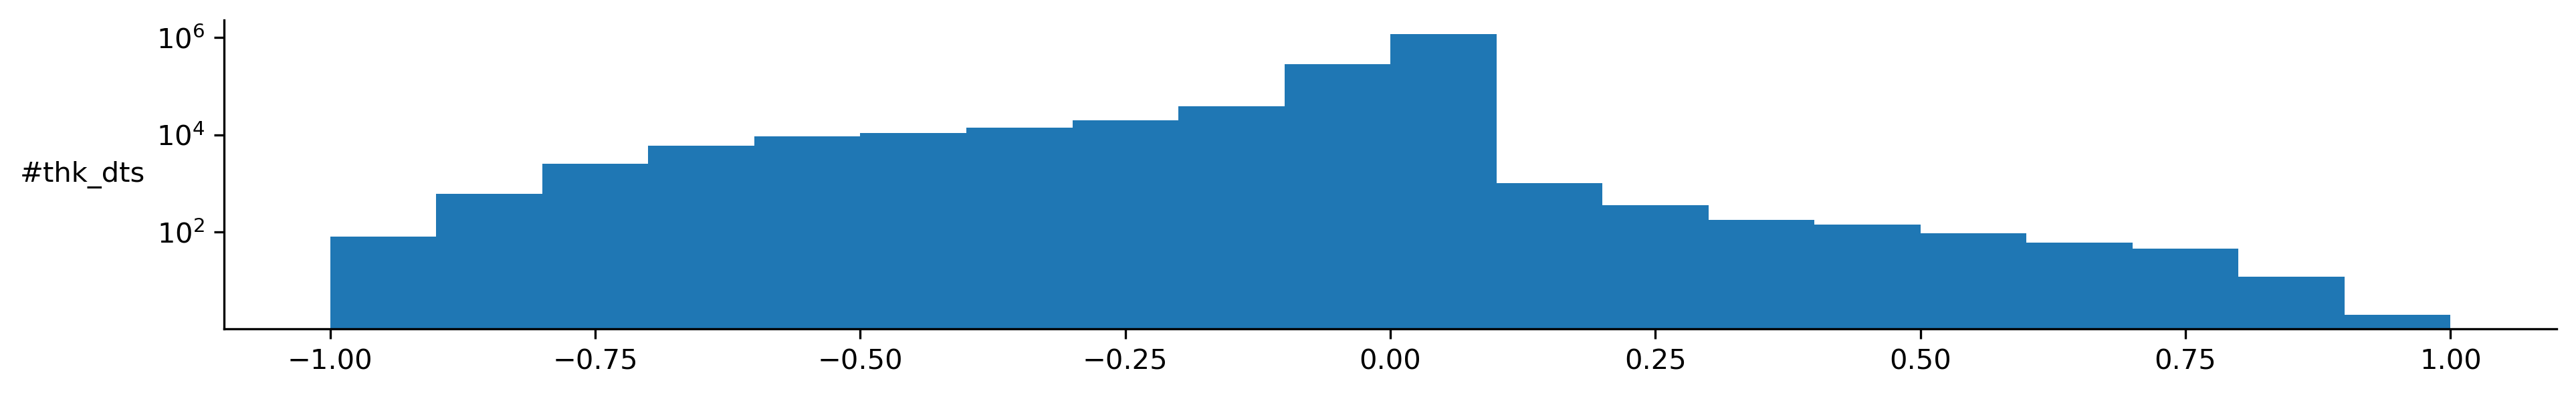

In [15]:
td.plotter().shifts_distribution()

Let's compute clusters now and plot the results


INFO: Applying clusterer HDBSCAN to thk_dts
INFO: Detected 33 clusters


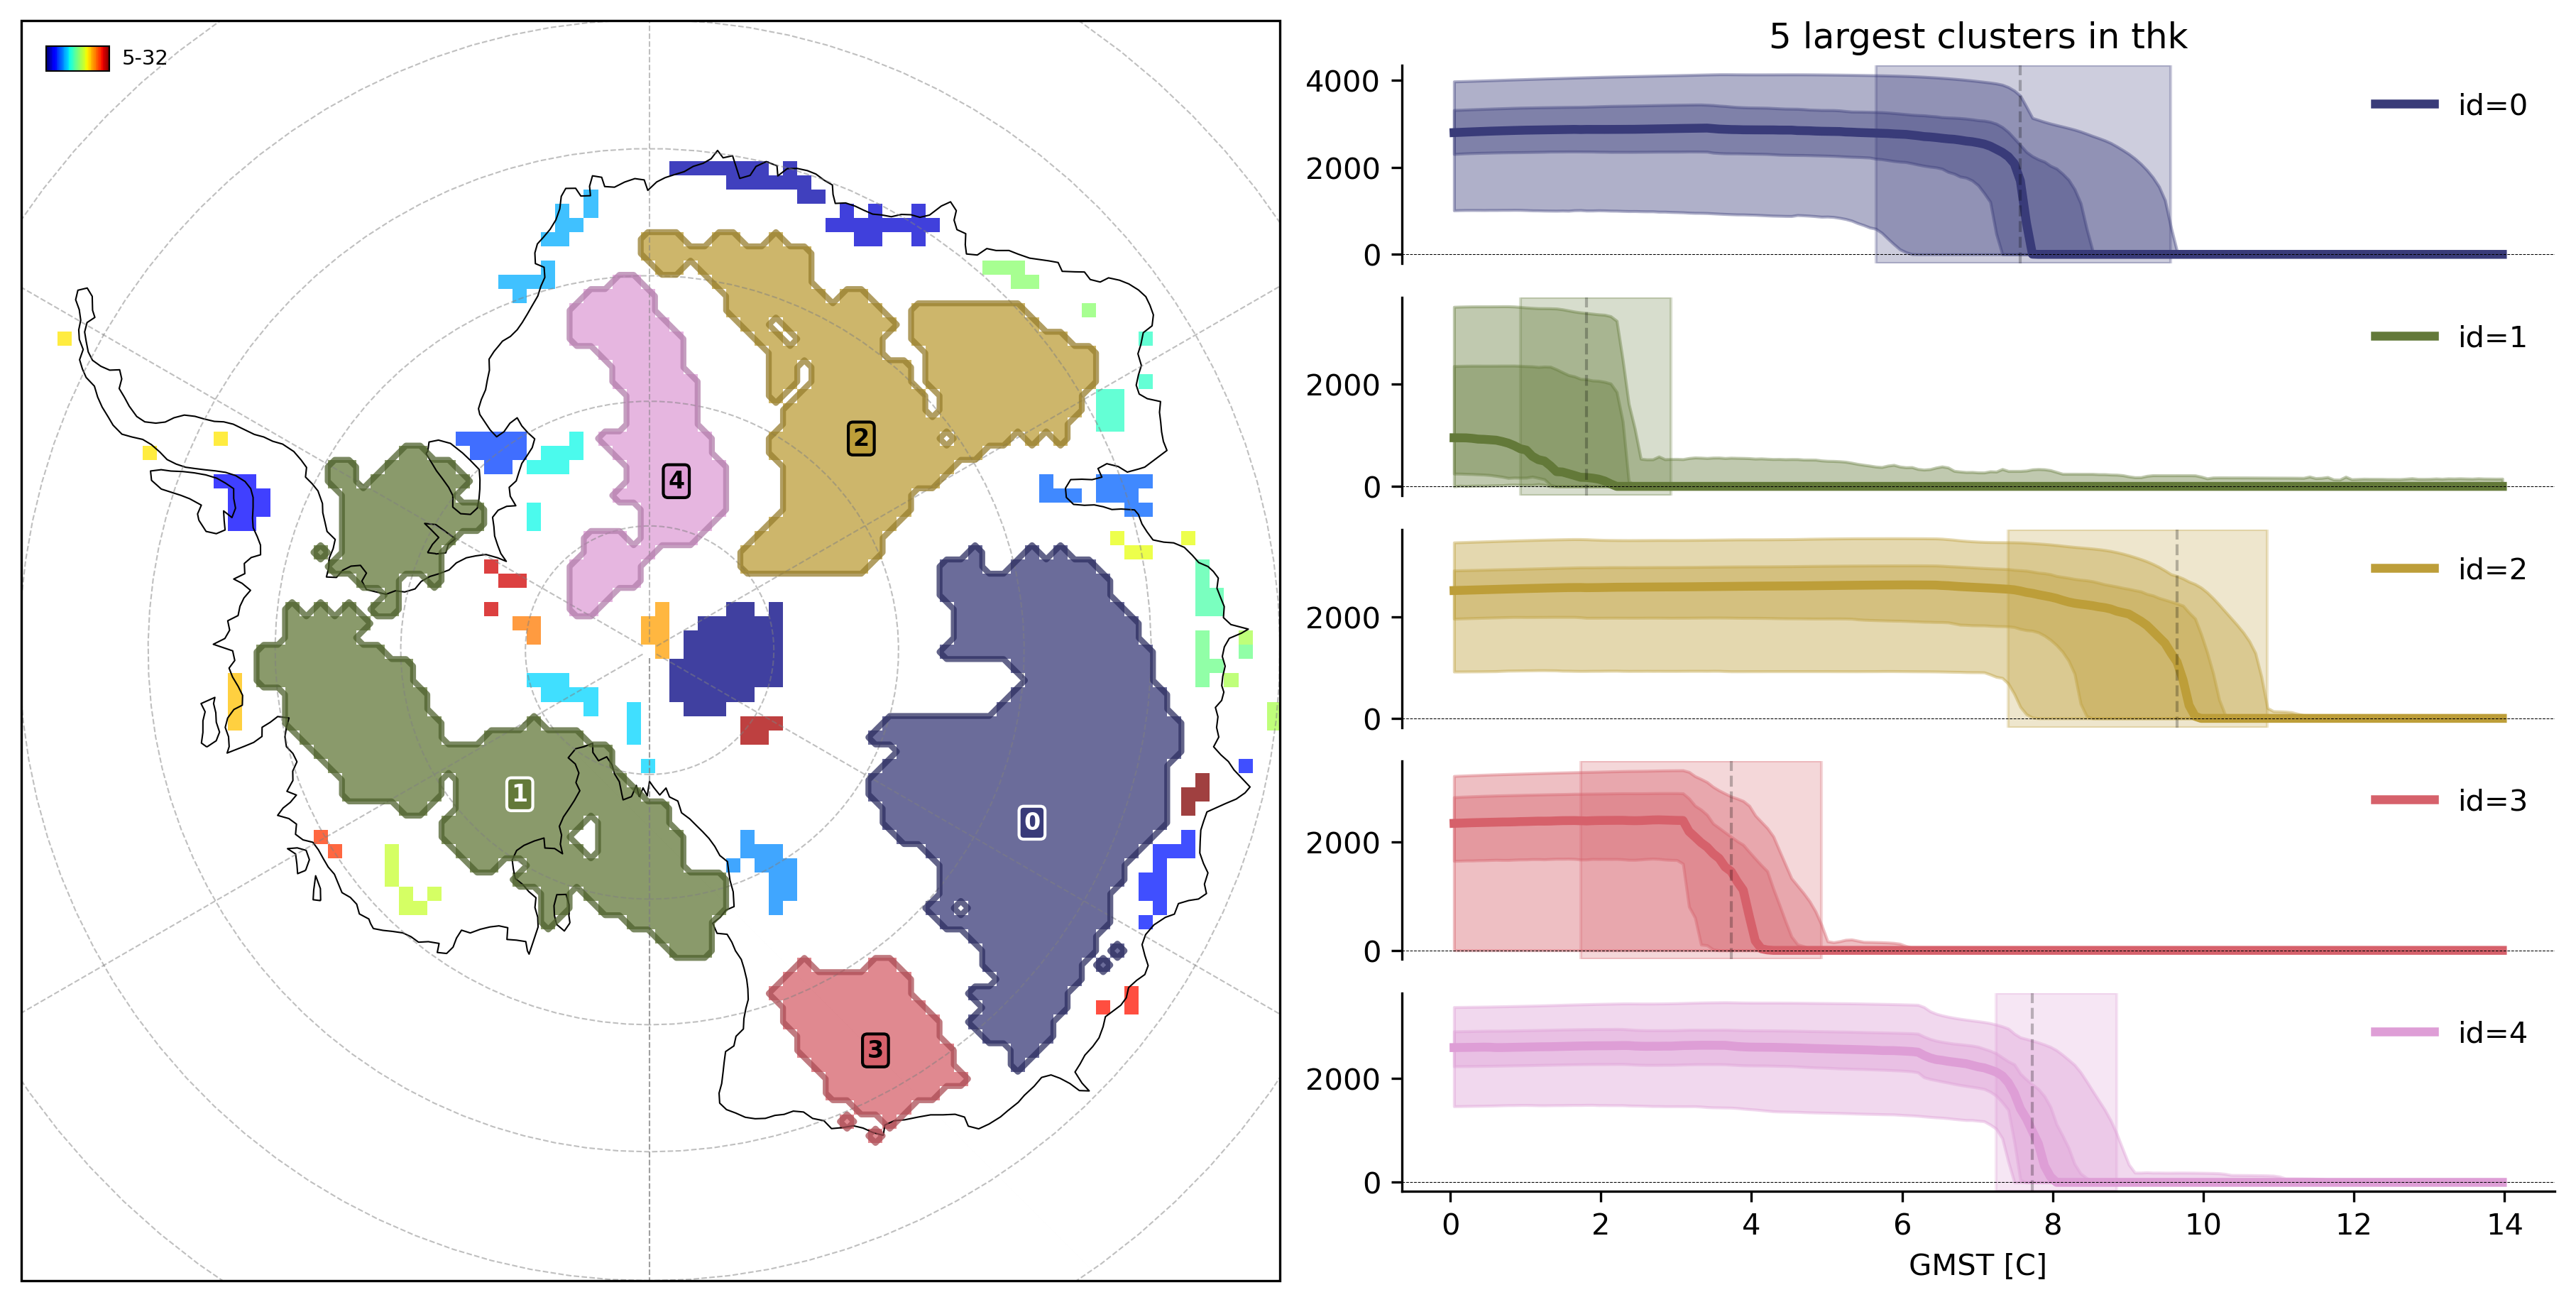

In [16]:
from sklearn.cluster import HDBSCAN

td.compute_clusters(
    "thk",
    method=HDBSCAN(min_cluster_size=10),
    shift_threshold=0.6,
    overwrite=True,
)

# plot 5 largest clusters
td.plotter().cluster_overview(
    "thk",
    cluster_ids=range(5),
    projection="south_pole",
);